In [19]:
import tarfile
import urllib.request
import os
import cv2
from skimage import transform
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, Flatten, Dropout
from keras.optimizers import Adam
from keras.models import load_model
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot as plt

In [ ]:
images_have_been_downloaded = True
if not images_have_been_downloaded:
    !wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
    !tar -xzf 102flowers.tgz
    !rm 102flowers.tgz

In [9]:
def load_data(directory, size=(64, 64)):
    # Check if preprocessed file already exists
    if os.path.exists('/kaggle/input/processed-oxford-flowers-images'):
        images = np.load('/kaggle/input/processed-oxford-flowers-images/preprocessed_images.npy')
    elif os.path.exists('/kaggle/working/preprocessed_images.npy'):
        images = np.load('/kaggle/working/preprocessed_images.npy')
    else:
        print('Preprocessed file not found. Loading and preprocessing images...')
        images = []
        for file in os.listdir('/kaggle/working/jpg'):
            if file.endswith(".jpg"):
                img = cv2.imread(os.path.join(directory, file))
                if img is not None:
                    # Normalize Pixel Values
                    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                    # Resize image
                    img = transform.resize(img, size)
                    images.append(img)
        images = np.array(images)
        # Save the preprocessed images for future use
        np.save('preprocessed_images.npy', images)
    return images

images = load_data('/kaggle/working/jpg')


In [14]:
# generator model
def define_generator(latent_dim):
    model = Sequential()
    model.add(Dense(256*4*4, input_dim=latent_dim))
    model.add(Reshape((4, 4, 256)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))  # added layer
    model.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))
    return model

# discriminator model
def define_discriminator(in_shape=(64,64,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [16]:
# Create GAN
def create_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# generate n real samples with class labels
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels, 1 for 'real'
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y
# train
def train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            # Get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # Generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)  # changed from gan_model to generator
            # Create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
             # Update discriminator model weights
            d_loss, _ = discriminator.train_on_batch(X, y)
            # Prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # Create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # Update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # Summarize loss on this batch
        print('>%d, d=%.3f, g=%.3f' % (i+1, d_loss, g_loss))
    # Save the generator model
    generator.save('generator.h5')


In [17]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = create_gan(generator, discriminator)
# load image data
dataset = images  # Assuming load_real_samples function is defined and loads the image data
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

2/2 [==============================] - 0s 10ms/step
>1, d=0.444, g=1.499
2/2 [==============================] - 0s 9ms/step
>2, d=0.382, g=1.364
2/2 [==============================] - 0s 9ms/step
>3, d=0.747, g=0.815
2/2 [==============================] - 0s 10ms/step
>4, d=0.643, g=0.936
2/2 [==============================] - 0s 10ms/step
>5, d=0.842, g=0.796
2/2 [==============================] - 0s 10ms/step
>6, d=0.649, g=0.878
2/2 [==============================] - 0s 10ms/step
>7, d=0.678, g=0.874
2/2 [==============================] - 0s 10ms/step
>8, d=0.545, g=0.981
2/2 [==============================] - 0s 10ms/step
>9, d=0.693, g=0.832
2/2 [==============================] - 0s 10ms/step
>10, d=0.688, g=0.742
2/2 [==============================] - 0s 10ms/step
>11, d=0.680, g=0.773
2/2 [==============================] - 0s 10ms/step
>12, d=0.641, g=0.806
2/2 [==============================] - 0s 10ms/step
>13, d=0.709, g=0.718
2/2 [==============================] - 0s 10ms/st

1/1 [==============================] - 0s 140ms/step


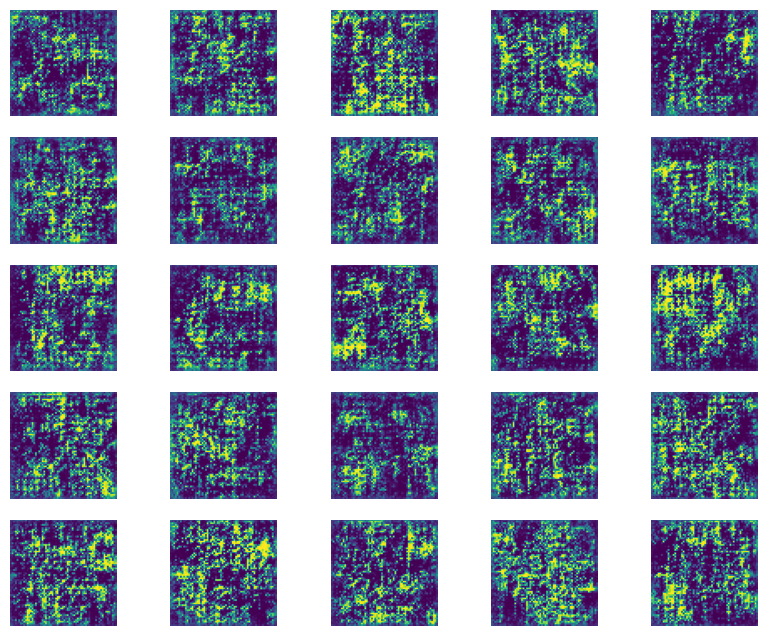

In [24]:

# Load the model
model = load_model('generator.h5')

# Generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
plt.figure(figsize=(10, 8))

# Plot the result
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(X[i, :, :, 0])
    #plt.imshow(X[i, :, :, 0], cmap='gray_r')
plt.show()

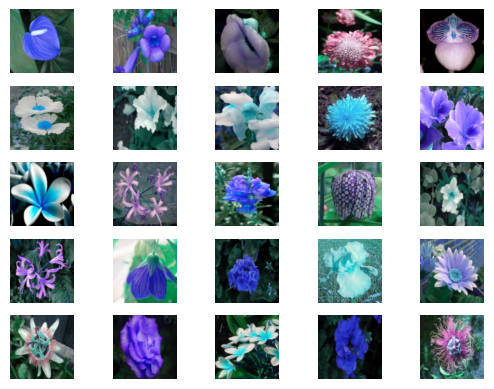

In [21]:
# Display the first 25 images from the 'images' variable
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(images[i])
plt.show()